# Label pipeline
In this notebook, we try out the entire pipeline - from D + semantic data, through building a semantic map,
to raytracing the labels back to the camera position

In [1]:
import os
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
from yacs.config import CfgNode

from src.config import default_map_builder_cfg, default_sim_cfg
from src.features.mapping import SemanticMap3DBuilder
from src.model.perception import map_processing
from src.model.perception.labeler import LabelGenerator
from src.utils import category_mapping
from src.utils.category_mapping import get_instance_index_to_reseal_name_dict
from src.utils.misc import get_semantic_map
from src.visualisation import instance_map_visualization
from src.visualisation.instance_map_visualization import visualize_2d_categorical_instance_map
from src.visualisation.semantic_map_visualization import (
    visualize_categorical_label_map,
    visualize_semantic_map,
)
from src.model.perception.model_wrapper import ModelWrapper

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if pathlib.PurePath(os.getcwd()).name == "notebooks":
    print(pathlib.PurePath(os.getcwd()).name)
    os.chdir("..")


notebooks


In [3]:
TRAJECTORY = "00006-HkseAnWCgqk"
DEPTH_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"
SEMANTIC_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/Semantic"
trajectory_name = TRAJECTORY.split("-")[1]
SEMANTIC_INFO_FILE = f"./data/raw/train/scene_datasets/hm3d/train/{TRAJECTORY}/{trajectory_name}.semantic.txt"


Create map builder

In [4]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 6
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [25, 1.5, 25]
map_builder_cfg.GET_ENTIRE_MAP = True
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


Create model

In [28]:
model_config = CfgNode()
model_config.USE_INITIAL_TRANSFORMS = True
model_config.SCORE_THRESHOLD = 0.5
model_config.MASK_THRESHOLD = 0.5
model = ModelWrapper(model_config)
model.cuda()

Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [29]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)
scene_index_to_category_index_map = category_mapping.get_scene_index_to_reseal_index_vectorized(SEMANTIC_INFO_FILE)

map_builder.clear()

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image / 255



for i in tqdm(range(0,400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    rgb_image = load_image(f"{RGB_IMAGE_DIR}/{i}.png")
    map = model(rgb_image)
    # saved_semantics = np.load(f"{SEMANTIC_MAP_DIR}/{i}.npy")
    # map = get_semantic_map(saved_semantics, scene_index_to_category_index_map, map_builder_cfg.NUM_SEMANTIC_CLASSES)
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(map, depth_map, pose)
    if i % 10 == 1:
        map_builder.update_semantic_map()

map_builder.update_semantic_map()
#map_builder.concatenate_semantics()
#print("Concatenating semantics done")
#map_builder.update_kdtree()


100%|██████████| 400/400 [00:49<00:00,  8.01it/s]


Get point cloud and visualize points with semantic information

In [31]:
plot_point_cloud = True

if plot_point_cloud:
    point_cloud = map_builder.point_cloud
    point_cloud_semantic_labels = map_builder._master_point_cloud_semantic_labels

    color_converter = category_mapping.get_reseal_index_to_color_vectorized()

    point_cloud_categorical = np.argmax(point_cloud_semantic_labels, axis=-1) + (np.sum(
        point_cloud_semantic_labels, axis=-1
    ) > 0).astype(int)
    # Need to initialize this as a 3 channel image so we can use numpy indexing to assign the points that have a label
    # instead of having to loop over them
    point_cloud_rgb = np.dstack([point_cloud_categorical] * 3)[0]
    #point_cloud_rgb[point_cloud_categorical > 0] = color_converter(point_cloud_categorical[point_cloud_categorical > 0])

    point_cloud_o3d = o3d.utility.Vector3dVector(point_cloud[point_cloud_categorical > 0])
    pcd = o3d.geometry.PointCloud(point_cloud_o3d)
    colour = color_converter(point_cloud_categorical[point_cloud_categorical > 0])
    pcd.colors = o3d.utility.Vector3dVector(colour)
    o3d.visualization.draw_geometries([pcd])


Get 3D semantic map (i.e. Voxel grid) at an index and plot it along with corresponding RGB image

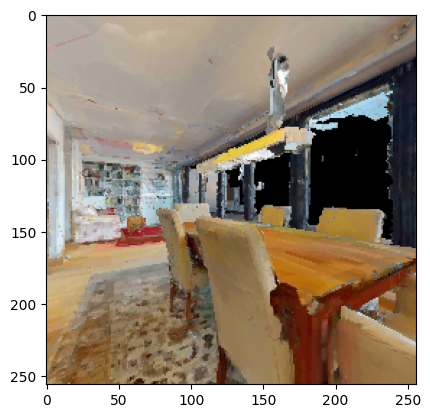

In [32]:
index = 322

rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)


In [33]:
semantic_map = map_builder.semantic_map

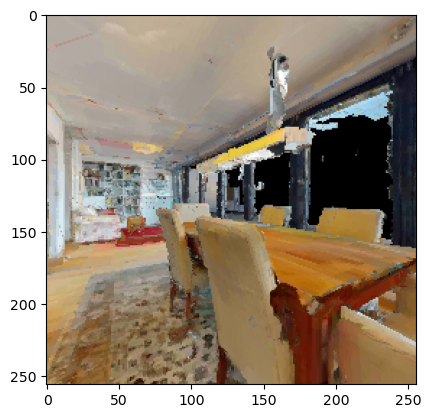

In [34]:
map_processor_cfg = CfgNode()
map_processor_cfg.NO_OBJECT_CONFIDENCE_THRESHOLD = 0.5
map_processor_cfg.HOLE_VOXEL_THRESHOLD = 2000
map_processor_cfg.OBJECT_VOXEL_THRESHOLD = 200
map_processor_cfg.DILATE = True

grid_index_of_origin = map_builder.get_grid_index_of_origin()

label_generator = LabelGenerator(semantic_map, grid_index_of_origin, map_builder_cfg, map_processor_cfg, sim_cfg.SENSOR_CFG)


Use MapProcessor to build label map and instance map

In [23]:
plotter = visualize_categorical_label_map(label_generator.categorical_label_map, opacity=0.1)

# If nothing shows up, try changing jupyter_backend="trame" to jupyter_backend="panel"
plotter.show(jupyter_backend="trame")

[149.  19. 149.]


Widget(value="<iframe src='http://localhost:33439/index.html?ui=P_0x7f0a98ac2220_0&reconnect=auto' style='widt…

In [12]:
plotter = instance_map_visualization.visualize_3d_categorical_instance_map(
    label_generator.categorical_instance_map, 
    label_generator.categorical_label_map, 
    0.1)
# If nothing shows up, try changing jupyter_backend="trame" to jupyter_backend="panel"
plotter.show(jupyter_backend="trame")

Widget(value="<iframe src='http://localhost:33439/index.html?ui=P_0x7f0ac9016370_1&reconnect=auto' style='widt…

Raytrace in instance map and show results

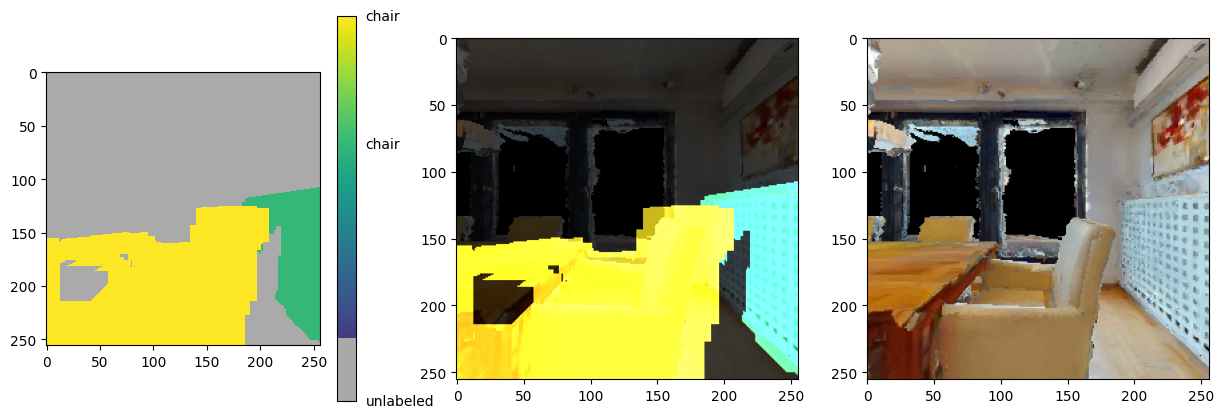

In [13]:
#index = 130
index = 320
pose = (positions[index], rotations[index])

instance_map_2d = label_generator.get_instance_map_2d(pose)
instance_label_to_reseal_name_dict = get_instance_index_to_reseal_name_dict(label_generator.categorical_instance_map, 
                                                                            label_generator.categorical_label_map)
rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255

visualize_2d_categorical_instance_map(instance_map_2d, rgb_image, instance_label_to_reseal_name_dict)
plt.show()

In [14]:
label_dict = label_generator.get_label_dict(pose)

In [15]:
model.train()
with torch.no_grad():
    loss = model(rgb_image, label_dict)

In [16]:
model.eval()
semantic_map_2d = model(rgb_image)

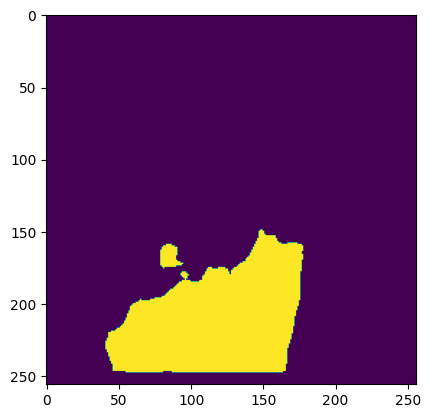

In [17]:
plt.imshow(semantic_map_2d.sum(axis=-1))